## This is an attempt to reconstruct Fig. 4 from the article O. Finke et. al. Monochromatic high-order harmonic generation by a Bessel-Gauss beam in periodically modulated media

In [29]:
# general imports
import copy
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from IPython.display import display, Latex
# imports for analytical
import XUV_refractive_index as XUV_index
import XUV_signal_computation2 as XUV_sig
import mynumerics as mn
import harmonic_signal as hs

## The goal is to optimize the 11th harmonic in Ar generated with 400 nm laser

In [30]:
# initial parameters
gas_type = 'Ar'
XUV_table_type_absorption = 'Henke' # {Henke, NIST}    
XUV_table_type_dispersion = 'Henke'
wavelength = 400e-9 #m
H_opt = 11

# laser  
omegaSI = mn.ConvertPhoton(wavelength, 'lambdaSI', 'omegaSI') 
pressure = 100e-3 # mbar


parameters = {'XUV_table_type_dispersion': XUV_table_type_dispersion,
              'XUV_table_type_absorption': XUV_table_type_absorption,
              'gas_type': gas_type,
              'omegaSI': omegaSI,
              'Aq' : 1.0}

def asymptotic_signal(p,omega):
    return 4.*((p*parameters['Aq'])**2)*XUV_index.L_abs(omega, pressure, gas_type + '_' + XUV_table_type_absorption)**2

## Contrast as a function of the number of periods while keeping the total length of the medium $3L_{\mathrm{abs}}$

To find the optimising parameters, we use a sample series of sample $l_1=0.2~\mathrm{mm}$. We investigate the signals and the contrast with the increasing number of periods. We impose the condition that the total length of the gas is $3L_{\mathrm{abs}}$.

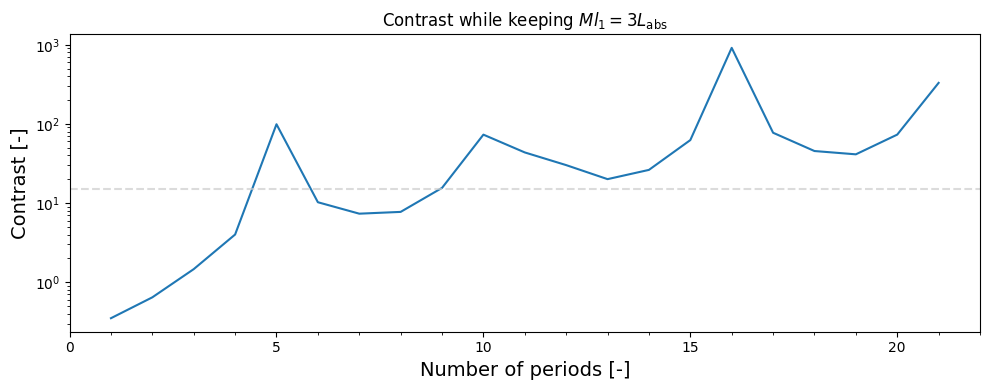

In [31]:
l1=0.2e-3
pressure_guess = 1e-3
L_abs_factor = 3.
delta_phi = np.pi/H_opt

# H_list = list(np.arange(23,66,2))
M_max = 2*H_opt

M_grid = np.arange(1, M_max)

# find optimal parameters of the generation
eta_opt = XUV_sig.eta_opt(H_opt, parameters)
eta_gen = 0.25*eta_opt # 0.0 # 0.5*eta_opt


H_interest = list(range(H_opt-6,H_opt+7,2))
H_compare = copy.deepcopy(H_interest)
H_compare.remove(H_opt)

pressure_grid = np.zeros((len(M_grid),))
zeta_opt = np.empty((len(M_grid),)); xi_opt = np.empty((len(M_grid),))
signal_list = []
contrasts = np.zeros((len(M_grid),))

for k1 in range(len(M_grid)):
    L_abs_p_f = lambda p: M_grid[k1]*l1 - L_abs_factor*XUV_index.L_abs(H_opt*omegaSI, p, gas_type + '_' + XUV_table_type_absorption)
    pressure_grid[k1] = sp.optimize.newton(L_abs_p_f, pressure_guess)
    # print(3*XUV_char.L_abs(gas_type + '_' + XUV_table_type_absorption, Horder_init*omegaSI, pressure_grid[k1]))
    zeta_opt[k1] = XUV_sig.zeta_single_segment(pressure_grid[k1], H_opt, eta_gen, parameters)
    xi_opt[k1] = XUV_sig.xi_calc_pm(delta_phi,pressure_grid[k1], l1, zeta_opt[k1], eta_gen, H_opt, parameters)
    signal_list.append(
        [XUV_sig.periodic_medium_signal(pressure_grid[k1], zeta_opt[k1], l1, xi_opt[k1], eta_gen, H_calc, M_grid[k1], parameters)[1] for H_calc in H_interest]
        )
    
    contrasts[k1] = XUV_sig.monochrom_function(H_interest, signal_list[k1], H_opt, H_compare, metric='max')

signals = np.asarray(signal_list)
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel("Number of periods [-]", fontsize=14)
ax.set_ylabel("Contrast [-]", fontsize=14)
ax.semilogy(M_grid, contrasts)
ax.axhline(y=15, color='0.8', linestyle='--', alpha=0.7)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.set_title(r'Contrast while keeping $Ml_1 = 3L_{\mathrm{abs}}$') 

plt.tight_layout()
# fig.savefig('Contrast_keeping_3Labs.pdf')
plt.show()


### Harmonic signal as a function of periods

pressure=67.9 mbar
zeta=2.1684307602854424e-05
theta_opt=6.585 mrad
xi=8.385
l1=0.2 mm
l2=1.68 mm
target_length=9.38 mm


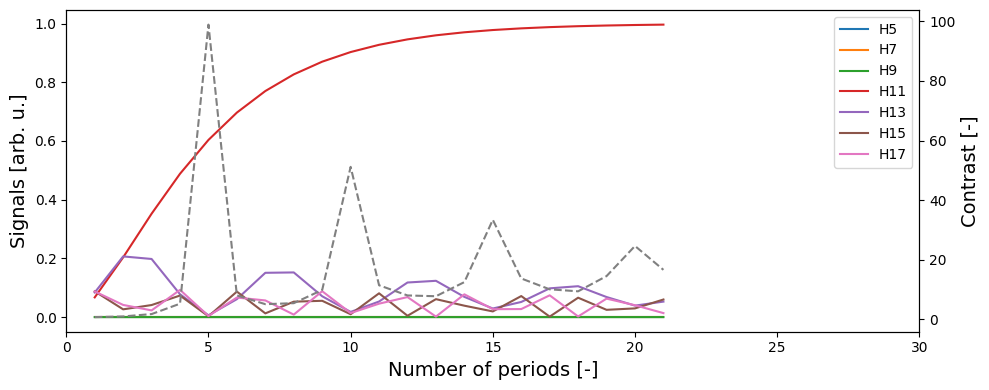

In [32]:
M_3Labs = 5

L_abs_p_f = lambda p: M_3Labs*l1 - L_abs_factor*XUV_index.L_abs(H_opt*omegaSI,
                p, gas_type + '_' + XUV_table_type_absorption)
pressure = sp.optimize.newton(L_abs_p_f, pressure_guess)
#pressure = 70e-3
print(f'pressure={pressure*1e3:.1f} mbar')

zeta_opt = XUV_sig.zeta_single_segment(pressure, H_opt, eta_gen, parameters)

theta_opt = XUV_sig.zeta2theta(zeta_opt)
xi_opt = XUV_sig.xi_calc_pm(delta_phi,pressure, l1, zeta_opt, eta_gen, H_opt, parameters)
l2_opt = l1*xi_opt
#print(f'zeta={zeta_opt}')
print(f'theta_opt={theta_opt*1e3:.3f} mrad')
print(f'xi={xi_opt:.3f}')
print(f'l1={l1*1e3} mm')
print(f'l2={l2_opt*1e3:.2f} mm')
print(f'target_length={(l1+l2_opt)*M_3Labs*1e3:.2f} mm')

# signals
signal_list = [XUV_sig.periodic_medium_signal(pressure, zeta_opt, l1, xi_opt, 
                                              eta_gen, H_calc, M_grid, 
                                              parameters)[1] for H_calc in H_interest]


# plot signals
sig_norm = asymptotic_signal(pressure,H_opt*omegaSI)
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.set_xlabel("Number of periods [-]", fontsize=14)
ax1.set_ylabel("Signals [arb. u.]", fontsize=14)
for k1 in range(len(H_interest)):
    ax1.plot(M_grid, signal_list[k1]/sig_norm, label= r"H"+str(H_interest[k1]))

plt.legend()

ax2 = ax1.twinx()
ax2.set_ylabel("Contrast [-]", fontsize=14)
#ax2.semilogy(M_grid, 
#             XUV_sig.monochrom_function(H_interest, signal_list, H_opt, 
#            H_compare, metric='max'),
#            linestyle = '--', color = 'grey', label = 'contrast')

ax2.plot(M_grid, 
            XUV_sig.monochrom_function(H_interest, signal_list, H_opt, 
            H_compare, metric='max'),
            linestyle = '--', color = 'grey', label = 'contrast')

plt.xlim(0,30)

#ax.set_title("Reference case")

plt.tight_layout()
plt.show()



### Conclusion:

Input parameters:
* Medium: Ar
* Laser wavelength: 400 nm
* Optimized harmonic: 11th (36.4 nm)
* Total length kept at 3Labs
* l1 = 0.2 mm

Optimized parameters:
* number of periods: 5
* l2_opt = 1.68 mm
* total medium length = 9.38 mm
* pressure = 67.9 mbar
* theta_opt = 6.585 mrad
